In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

%matplotlib widget

def getPowerInInterval(input):
    dates, values = zip(*input) if input else ([], [])
    #print(dates)
    # Create the first datetime variable
    datetime_var1 = datetime(1900, 1, 1, 0, 1, 0)  # Year, Month, Day, Hour, Minute, Second

    # Create the second datetime variable
    datetime_var2 = datetime(1900, 1, 1, 0, 21, 0)  # Year, Month, Day, Hour, Minute, Second

    # Find the first datetime after datetime_var1
    first = 0
    last = 0
    for i in range(len(dates)):
        if dates[i].timestamp() > datetime_var1.timestamp():
            first = i
            break

    for i in range(len(dates)):
        if dates[i].timestamp() > datetime_var2.timestamp():
            last = i - 1
            break
    #print(last, first)
    return values[last] - values[first]

def getReceptionRate(s, c):
    dates, sentValues = zip(*s) if s else ([], [])
    cdates, cstate = zip(*c) if c else ([], [])
    #print(dates)
    # Create the first datetime variable
    datetime_var1 = datetime(1900, 1, 1, 0, 1, 0)  # Year, Month, Day, Hour, Minute, Second

    # Create the second datetime variable
    datetime_var2 = datetime(1900, 1, 1, 0, 21, 0)  # Year, Month, Day, Hour, Minute, Second

    # Find the first datetime after datetime_var1
    first = 0
    last = 0
    for i in range(len(dates)):
        if dates[i].timestamp() > datetime_var1.timestamp():
            first = i
            break

    for i in range(len(dates)):
        if dates[i].timestamp() > datetime_var2.timestamp():
            last = i - 1
            break


    lostCounter = 0
    for i in range(len(cdates)):
        if cdates[i].timestamp() > datetime_var1.timestamp():
            if cdates[i].timestamp() < datetime_var2.timestamp():
                #print(cstate[i])
                lostCounter += cstate[i] == 0

    #print(lostCounter)
    #print(last, first)
    return ((sentValues[last] - sentValues[first]) - lostCounter) / (sentValues[last] - sentValues[first])

#file_path = 'loglisteners/kvs29.txt'  # Replace with the path to your text file
def plotScenario(file_path, plot=False):
    #file_path = 'scenarios/random3_60.txt'
    def extract_tx_rx_state_power_data(line):
        timestamp = line.split("\t")[0]
        if "TX:" in line and "RX:" in line:
            tx_value, rx_value = map(int, line.split("TX: ")[1].split(", RX: "))
            return timestamp, tx_value, rx_value, None, None, None, None, None, None, None, None
        elif "state:" in line:
            state_value = int(line.split("state: ")[1])
            return timestamp, None, None, state_value, None, None, None, None, None, None, None
        elif "Total power usage A" in line:
            power_value_A = float(line.split("Total power usage A =")[1].split("mAh")[0].strip())
            return timestamp, None, None, None, power_value_A, None, None, None, None, None, None
        elif "Total power usage B" in line:
            power_value_B = float(line.split("Total power usage B =")[1].split("mAh")[0].strip())
            return timestamp, None, None, None, None, power_value_B, None, None, None, None, None
        elif "Total power usage C" in line:
            power_value_C = float(line.split("Total power usage C =")[1].split("mAh")[0].strip())
            return timestamp, None, None, None, None, None, power_value_C, None, None, None, None
        elif "Sending B" in line: 
            return timestamp, None, None, None, None, None, None, 1024*0.7, None, None, None
        elif "Sending C" in line: 
            return timestamp, None, None, None, None, None, None, None, 1024*0.5, None, None
        elif "Sent: " in line and "Received: " in line:
            sent, received = map(int, line.split("Sent: ")[1].split(", Received: "))
            return timestamp, None, None, None, None, None, None, None, None, sent, received
        
        return timestamp, None, None, None, None, None, None, None, None, None, None
    def parse_power_data(power_values):
        corrected_values = []
        previous_value = 0
        for timestamp, value in power_values:
            if value < previous_value:
                value += 65522.8896  # Adjust for reset
            corrected_values.append((timestamp, value))
            previous_value = value
        return corrected_values
    def parse_timestamp(timestamp):
        # Check if the timestamp includes hours
        if len(timestamp.split(':')) == 3:
            return datetime.strptime(timestamp, '%H:%M:%S.%f')
        else:
            # Add a dummy hour for timestamps without hours and convert to datetime
            return datetime.strptime('00:' + timestamp, '%H:%M:%S.%f')

    timestamps = []
    tx_rx_ratios = []
    state_values = []
    power_values_A = []
    power_values_B = []
    power_values_C = []
    power_diff_A = []
    power_diff_B = []
    power_diff_C = []
    sendingB = []
    sendingC = []
    sentPackets = []
    receivedPackets = []

    ENERGEST_SECOND = 32767
    with open(file_path, 'r') as file:
        for line in file:
            timestamp, tx_value, rx_value, state_value, power_value_A, power_value_B, power_value_C, sending_B, sending_C, sent, received = extract_tx_rx_state_power_data(line.strip())
            if timestamp is not None:
                timestamp = parse_timestamp(timestamp)
                timestamps.append(timestamp)
                if tx_value is not None and rx_value is not None:
                    tx_rx_ratio = rx_value / tx_value if rx_value != 0 else 0
                    tx_rx_ratios.append((timestamp, min(tx_rx_ratio, 1024)))
                if state_value is not None:
                    state_values.append((timestamp, state_value/100))
                if power_value_A is not None:
                    power_value_A = power_value_A / ENERGEST_SECOND
                    if power_values_A != []:
                        power_diff_A.append((timestamp, (power_value_A - power_values_A[-1][1]) / (timestamp.timestamp() - power_values_A[-1][0].timestamp())))
                    power_values_A.append((timestamp, power_value_A))
                    #power_diff.append((timestamp, power_value_A - power_values_A[-1][1]))
                if power_value_B is not None:
                    power_value_B = power_value_B / ENERGEST_SECOND
                    if power_values_B != []:
                        power_diff_B.append((timestamp, (power_value_B - power_values_B[-1][1]) / (timestamp.timestamp() - power_values_B[-1][0].timestamp())))
                    power_values_B.append((timestamp, power_value_B))
                if power_value_C is not None:
                    power_value_C = power_value_C / ENERGEST_SECOND
                    if power_values_C != []:
                        power_diff_C.append((timestamp, (power_value_C - power_values_C[-1][1]) / (timestamp.timestamp() - power_values_C[-1][0].timestamp())))
                    power_values_C.append((timestamp, power_value_C))
                    #power_diff.append((timestamp, power_value_C - power_values_C[-2][1]))
                if sending_B is not None:
                    sendingB.append((timestamp, sending_B))
                if sending_C is not None:
                    sendingC.append((timestamp, sending_C))
                if sent is not None and received is not None:
                    sentPackets.append((timestamp, sent))
                    receivedPackets.append((timestamp, received))

                    
    power_values = parse_power_data(power_values_A)
    power_diff = power_diff_A
    # Preparing data for plotting
    tx_rx_times, tx_rx_data = zip(*tx_rx_ratios) if tx_rx_ratios else ([], [])
    state_times, state_data = zip(*state_values) if state_values else ([], [])
    #power_times, power_data = zip(*power_values) if power_values else ([], [])
    power_times, power_diff_data = zip(*power_diff) if power_diff else ([], [])
    sendingB_times, sendingB_data = zip(*sendingB) if sendingB else ([], [])
    sendingC_times, sendingC_data = zip(*sendingC) if sendingC else ([], [])

    if plot:
        # Plotting the data
        fig, axs = plt.subplots(3, figsize=(14, 8), gridspec_kw={'height_ratios': [2, 1, 2]}, sharex=True)

        # Plot TX/RX Ratio
        list1_dates = sendingB_times
        list2_dates = sendingC_times

        all_dates = sorted(list1_dates + list2_dates)

        for i in range(len(all_dates) - 1):
            start_date = all_dates[i]
            end_date = all_dates[i + 1]

            if start_date in list1_dates:
                axs[0].axvspan(start_date, end_date, facecolor='blue', alpha=0.2)
            elif start_date in list2_dates:
                axs[0].axvspan(start_date, end_date, facecolor='red', alpha=0.5)

        #axs[0].plot(tx_rx_times, tx_rx_data, color='blue', linewidth=2)
        axs[0].step(tx_rx_times, tx_rx_data, color='blue', linewidth=1, where='mid')
        #axs[0].plot([tx_rx_times[0], tx_rx_times[-1]], [0.9, 0.9])
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('RX/TX Ratio')
        axs[0].set_title('RX/RX Ratio, State, and Power Consumption Over Time')

        # Plot State
        axs[1].scatter(state_times, state_data, marker='o', color='red')
        axs[1].set_ylabel('State')

        # Plot Power Consumption
        axs[2].step(power_times, power_diff_data, color='green')
        axs[2].set_xlabel('Time') 
        axs[2].set_ylabel('Power Consumption (mAh)')

        # Format the x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator())
        plt.gcf().autofmt_xdate()  # Rotate date labels
        plt.grid(True)
        plt.show()

    # Print the datetime variables
    #print("A: ", getPowerInInterval(power_values_A))
    #print("B: ",getPowerInInterval(power_values_B))
    #print("C: ",getPowerInInterval(power_values_C))
    print("Total power: ", getPowerInInterval(power_values_A) + getPowerInInterval(power_values_B) + getPowerInInterval(power_values_C))

    print("R/S: ", getReceptionRate(sentPackets, state_values))

    return getPowerInInterval(power_values_A) + getPowerInInterval(power_values_B) + getPowerInInterval(power_values_C), getReceptionRate(sentPackets, state_values)


In [12]:
pows = []
rs = []
for i in range(8):
    p, r = plotScenario(f"scenarios/random3_{i}.txt")
    pows.append(p)
    rs.append(r)


Total power:  493.34664067506935
R/S:  0.802161263507897
Total power:  505.3936162907804
R/S:  0.8229508196721311
Total power:  515.6450621051667
R/S:  0.8318440292445166
Total power:  538.6879463332011
R/S:  0.8774860779634049
Total power:  570.8140068514053
R/S:  0.9182098765432098
Total power:  576.9826635792108
R/S:  0.9454265949269792
Total power:  586.9790013580737
R/S:  0.9626524390243902
Total power:  604.1593352305673
R/S:  0.9722013523666416


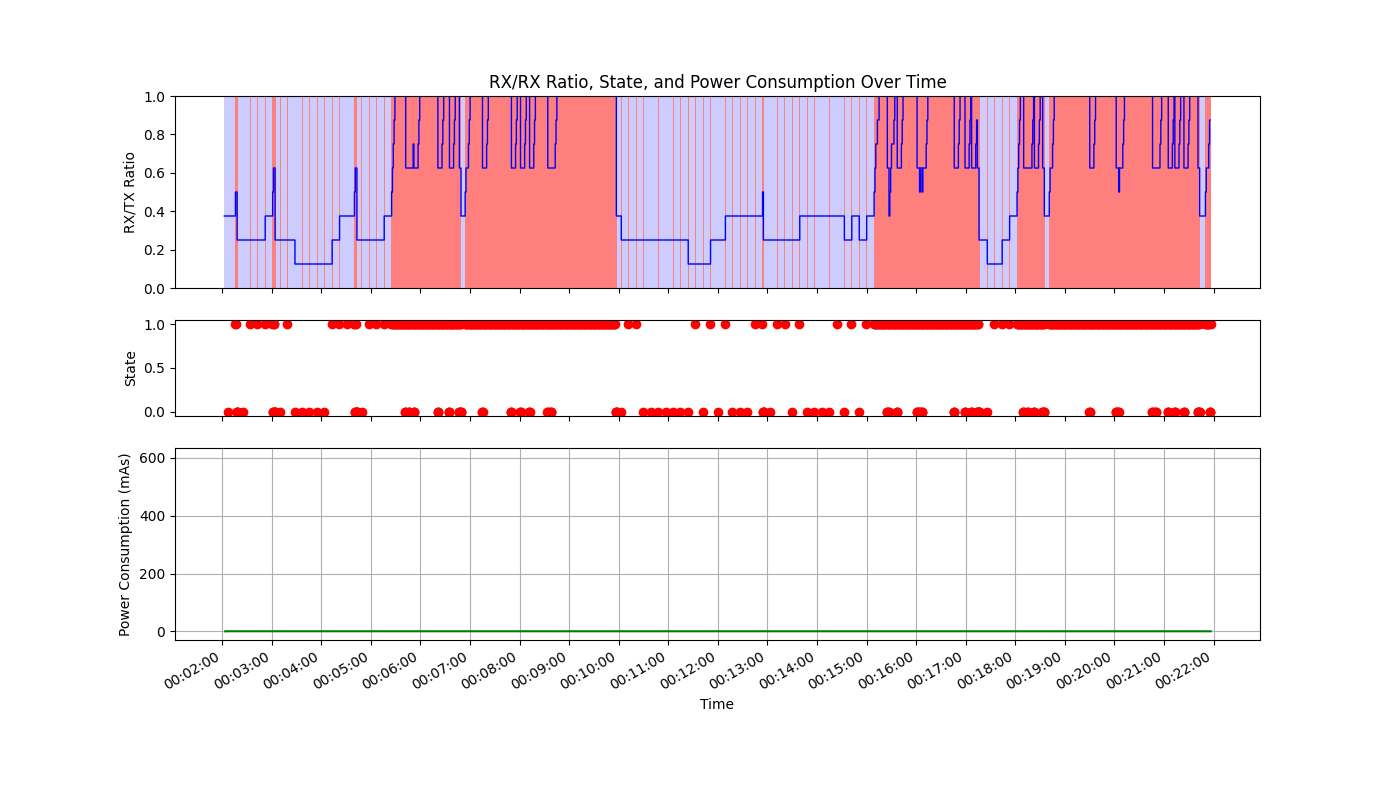

In [13]:
plt.plot(range(8), pows)
plt.show()


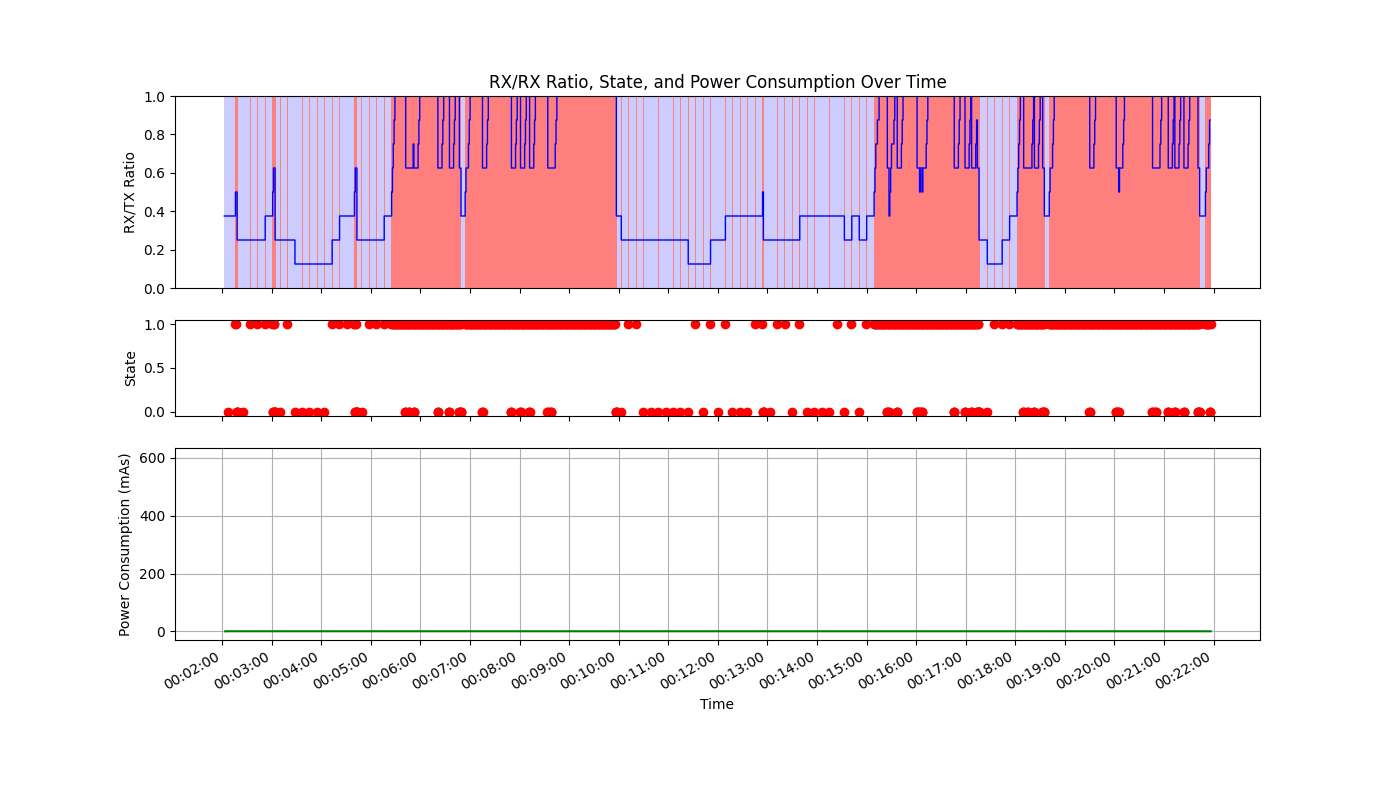

In [14]:
plt.plot(range(8), rs)
plt.show()

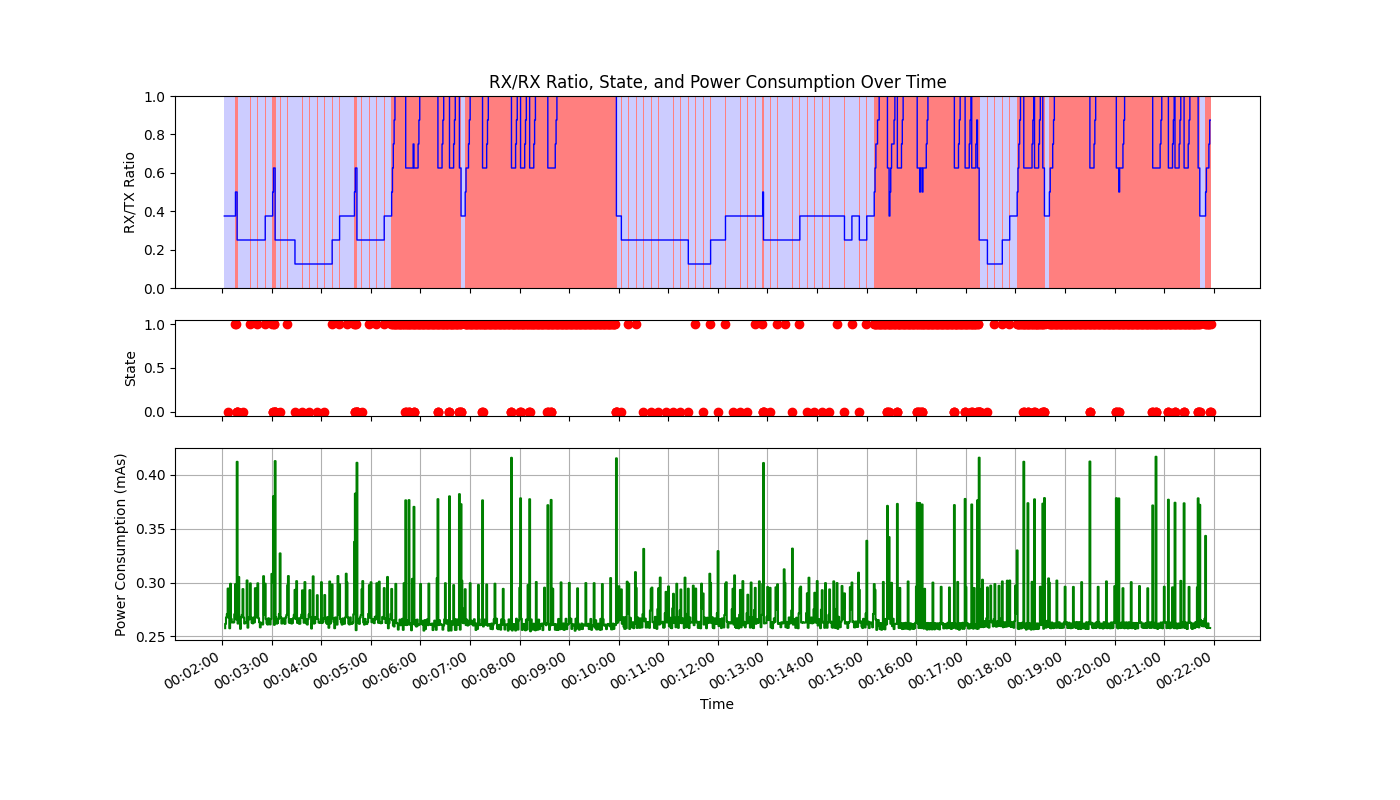

Total power:  646.1862086855679
R/S:  0.8753753753753754


(646.1862086855679, 0.8753753753753754)

In [15]:
plotScenario("scenarios/step3_3.txt", True)